# Carica i dati

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.2")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.plots") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.plots") \
    .getOrCreate()

plots_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
plots_df.show()

+---------+--------------------+--------------------+
|      _id|       plot_synopsis|               title|
+---------+--------------------+--------------------+
|tt0000091|The film opens wi...| Le manoir du diable|
|tt0000225|A widower merchan...| La belle et la bête|
|tt0000230|A prologue in fro...|          Cendrillon|
|tt0000417|At a meeting of t...|Le voyage dans la...|
|tt0000488|Joe is an impover...|The Land Beyond t...|
|tt0000634|Mark Antony – one...|Antony and Cleopatra|
|tt0000709|The play opens wi...|       Julius Caesar|
|tt0000966|The play consists...|A Midsummer Night...|
|tt0001223|The film starts w...|        Frankenstein|
|tt0001227|Dr. Richard Kimbl...|        The Fugitive|
|tt0001724|Two men who are f...|The Last Drop of ...|
|tt0001915|=== Book the Firs...|A Tale of Two Cities|
|tt0002130|The exhumation of...|           L'Inferno|
|tt0003419|Being praised as ...|Der Student von Prag|
|tt0003489|In Pompeii 79AD, ...|Gli ultimi giorni...|
|tt0004022|The play opens wi

# Divisione training-test e pulizia degli ID

In [3]:
from pyspark.sql.types import *

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.metadata") \
    .getOrCreate()
traintest_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
joined_tt_df = plots_df.join(traintest_df, plots_df._id == traintest_df._id, how='inner')
joined_tt_rdd = joined_tt_df.rdd\
                .map(lambda x: (int(x[0].lstrip('t0')), x[4], x[1], x[2]))

plots_schema = StructType([StructField('id', IntegerType(), True)\
                      , StructField('type', StringType(), True)\
                      , StructField('plot', StringType(), True)\
                      , StructField('title', StringType(), True)])
plots_ids_df = spark.createDataFrame(joined_tt_rdd, schema=plots_schema)
plots_ids_df.show()

+-----+-----+--------------------+--------------------+
|   id| type|                plot|               title|
+-----+-----+--------------------+--------------------+
|21156|train|The film is set i...|             Morocco|
|32553|train|During a battle i...|  The Great Dictator|
|34269|  val|Two Confederate v...|               Texas|
|38958|train|So Dark the Night...|   So Dark the Night|
|39305| test|Leaving a church,...|      Dead Reckoning|
|39431|train|The film is set i...|           Good News|
|39896|train|After the prosecu...|They Won't Believ...|
|42475| test|The cat is fishin...| A Fractured Leghorn|
|42899|train|A car pulls up to...|      Rocky Mountain|
|43973| test|Insurance investi...|           Roadblock|
|52811| test|In 1828 Edinburgh...|The Flesh and the...|
|53320|train|Alcoholic Bart Hu...|      A Summer Place|
|54152|train|In the first shot...|   Our Man in Havana|
|54289| test|After the death o...|  Il sepolcro dei re|
|54446|train|Kreton (Jerry Lew...|Visit to a Sma

# Join per la corrispondenza trama-genere

In [4]:
spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.ids") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.ids") \
    .getOrCreate()
ids_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
joined_ids_df = plots_ids_df.join(ids_df, plots_ids_df.id == ids_df.tmdbId, how='inner')

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .getOrCreate()
metadata_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
id_genres = metadata_df.select(['_id', 'genres']).rdd\
    .filter(lambda x: x.genres)\
    .map(lambda x: (int(x._id), int(x.genres[0])))

id_genres_schema = StructType([StructField('id_gen', IntegerType(), True)\
                      , StructField('label', IntegerType(), True)])
id_genres_df = spark.createDataFrame(id_genres, schema=id_genres_schema)
joined_genres_df = joined_ids_df.join(id_genres_df, joined_ids_df.imdbId == id_genres_df.id_gen, how='inner')
joined_genres_df = joined_genres_df.select('imdbId', 'type', 'label', 'title', 'plot')
joined_genres_df.show()

+------+-----+-----+--------------------+--------------------+
|imdbId| type|label|               title|                plot|
+------+-----+-----+--------------------+--------------------+
| 26755|train|   99|     Dressed to Kill|Kate Miller (Angi...|
| 41890| test|   35|              Topper|** CONTAINS SPOIL...|
| 43852|  val|   12|   Hansel and Gretel|Hansel and Gretel...|
| 73091|train|10752|        Ciao maschio|Dark surreal view...|
| 36706|train|   35|               Decoy|The story picks u...|
| 27214|train|   27| Anatomy of a Murder|In the Upper Peni...|
| 41530|train|10749|          Cry Danger|Rocky Mulloy was ...|
| 76083|  val|   28|        No Good Deed|In Tennessee, a p...|
| 29453|train|   18|           Curly Top|Young Elizabeth B...|
| 55198| test|   18|        The Gangster|Shubunka is a rac...|
|106922|train|   28|Phone Call from a...|After his wife Ja...|
| 62432|train|  878|            The Jerk|Navin R. Johnson,...|
| 38427| test|   18|Kaijûtô no kessen...|A team of scie

# Trova le parole più usate

In [5]:
mapped = plots_df.rdd\
    .map(lambda x: x.plot_synopsis.replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('"', ' ')\
    .replace('*', ' ').replace('(', ' ').replace(')', ' ').replace('=', ' ').lower())\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: len(x) > 2)\
    .map(lambda x: (x, 1))

occurrences = mapped.reduceByKey(lambda x, y: x + y).collect()
occurrences.sort(key=lambda x: x[1], reverse=True)
occurrences

[('the', 843343),
 ('and', 477047),
 ('his', 178188),
 ('that', 164163),
 ('her', 156598),
 ('with', 130223),
 ('him', 112117),
 ('she', 109714),
 ('for', 92947),
 ('they', 81926),
 ('but', 74178),
 ('from', 59490),
 ('who', 58843),
 ('has', 55778),
 ('out', 50417),
 ('are', 50214),
 ('their', 46490),
 ('when', 46463),
 ('into', 43212),
 ('them', 41557),
 ('after', 39716),
 ('was', 36782),
 ('then', 33253),
 ('tells', 32059),
 ('one', 31931),
 ('not', 30732),
 ('about', 30101),
 ('back', 29643),
 ('which', 27053),
 ('have', 26573),
 ('will', 26091),
 ('while', 26066),
 ('where', 25307),
 ('all', 24029),
 ('this', 23113),
 ('off', 22583),
 ('two', 20834),
 ('before', 19648),
 ('man', 19589),
 ('had', 19512),
 ('been', 18418),
 ('over', 18400),
 ('get', 18225),
 ('down', 17718),
 ('time', 17555),
 ('house', 17367),
 ('says', 16921),
 ('goes', 16810),
 ('only', 16656),
 ('other', 16519),
 ('can', 16499),
 ('home', 16398),
 ('there', 16347),
 ('find', 16039),
 ('later', 15501),
 ('asks', 1

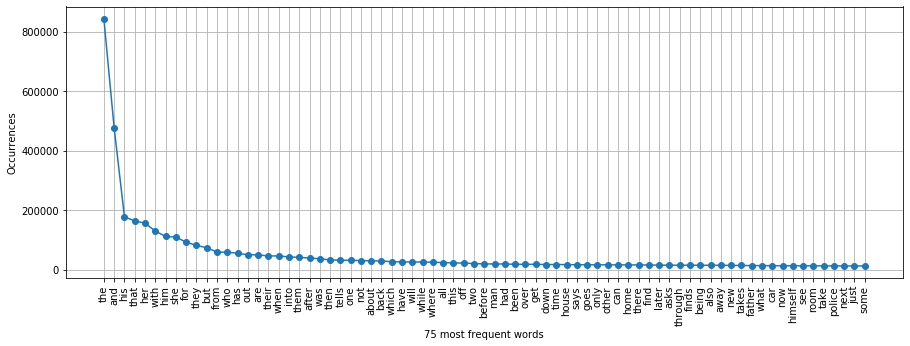

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([x[0] for x in occurrences[:75]], [x[1] for x in occurrences[:75]], marker='o')
plt.xticks(rotation=90)
plt.xlabel('75 most frequent words')
plt.ylabel('Occurrences')
plt.show()

## Vocabolario da 1000 parole

In [25]:
n_words = 1000

vocabulary = [occurrences[x][0] for x in range(n_words)]
vocabulary.sort()
vocabulary

['000',
 'abandoned',
 'able',
 'about',
 'accepts',
 'accident',
 'accidentally',
 'across',
 'act',
 'actually',
 'adam',
 'admits',
 'affair',
 'after',
 'again',
 'against',
 'agent',
 'agents',
 'ago',
 'agrees',
 'air',
 'alan',
 'alex',
 'alice',
 'alien',
 'alive',
 'all',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'american',
 'among',
 'amy',
 'and',
 'angry',
 'ann',
 'anna',
 'anne',
 'another',
 'any',
 'anyone',
 'anything',
 'apartment',
 'apparently',
 'appear',
 'appears',
 'approaches',
 'are',
 'area',
 'arm',
 'arms',
 'army',
 'around',
 'arrest',
 'arrested',
 'arrive',
 'arrives',
 'arthur',
 'ask',
 'asked',
 'asking',
 'asks',
 'attack',
 'attacked',
 'attacks',
 'attempt',
 'attempts',
 'attention',
 'audience',
 'away',
 'baby',
 'back',
 'bad',
 'band',
 'bank',
 'bar',
 'base',
 'basement',
 'bathroom',
 'battle',
 'beach',
 'beautiful',
 'because',
 'become',
 'becomes',
 'bed',
 'bedroom',
 'been',
 'before',
 

# Trasformazione dei dati nel formato adatto

In [29]:
import numpy as np
from pyspark.ml.linalg import Vectors

def dict_func(x, y):
    z = dict()
    z.update(x)
    z.update(y)
    return z

def featurisation(x):
    occ_vect = []
    plot_terms = x[1]
    for term in vocabulary:
        if term in plot_terms:
            occ_vect.append(plot_terms[term])
        else:
            occ_vect.append(0)
    return (x[0], Vectors.dense(occ_vect))

counted_rdd = joined_genres_df.rdd\
    .map(lambda x: (x[0], x[4]))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('"', ' ')\
    .replace('*', ' ').replace('(', ' ').replace(')', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

id_words_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary)\
    .map(lambda x: (x[0].split('.')[0], [x[0].split('.')[1], x[1]]))

counted_rdd = joined_genres_df.rdd\
    .map(lambda x: (x[0], x[4]))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('"', ' ')\
    .replace('*', ' ').replace('(', ' ').replace(')', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

features_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary)\
    .map(lambda x: (x[0].split('.')[0], {x[0].split('.')[1]: x[1]}))\
    .filter(lambda x: type(x[1]) is dict and type(x) is not None)\
    .reduceByKey(dict_func).map(featurisation)

spark = SparkSession.builder.appName('Words DF').getOrCreate()
vocab_words_df = spark.createDataFrame(features_rdd, ['feat_id', 'features'])
vocab_words_df.show()

+-------+--------------------+
|feat_id|            features|
+-------+--------------------+
|  96288|[1.0,0.0,0.0,0.0,...|
|  11904|[0.0,1.0,0.0,3.0,...|
|  53419|[0.0,0.0,1.0,0.0,...|
|  77270|[0.0,0.0,0.0,1.0,...|
|  39495|[0.0,0.0,0.0,3.0,...|
| 116014|[0.0,0.0,0.0,1.0,...|
|  72886|[0.0,0.0,1.0,0.0,...|
|  94405|[0.0,0.0,0.0,7.0,...|
|  27214|[0.0,0.0,0.0,0.0,...|
|  62006|[2.0,0.0,0.0,0.0,...|
|  41530|[1.0,0.0,1.0,1.0,...|
|  52017|[0.0,0.0,0.0,0.0,...|
| 114047|[0.0,0.0,0.0,4.0,...|
|  67276|[2.0,0.0,0.0,0.0,...|
|  42367|[0.0,0.0,0.0,0.0,...|
|  52278|[0.0,0.0,0.0,0.0,...|
|  43084|[0.0,0.0,0.0,2.0,...|
| 108346|[0.0,0.0,1.0,3.0,...|
|  41587|[0.0,0.0,0.0,1.0,...|
| 106922|[0.0,0.0,0.0,4.0,...|
+-------+--------------------+
only showing top 20 rows



# Divisione tra training, test e validazione

In [36]:
type_df = vocab_words_df.join(joined_genres_df, vocab_words_df.feat_id == joined_genres_df.imdbId)\
    .select('label', 'type', 'features')

genres_list = type_df.select('label').distinct().rdd.map(lambda x: x[0]).collect()
new_genres = dict()
i = 0
for g in genres_list:
    new_genres[g] = i
    i = i + 1

training_data = type_df.filter(type_df.type == 'train').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))
test_data = type_df.filter(type_df.type == 'test').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))
validation_data = type_df.filter(type_df.type == 'val').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))

training_data_df = spark.createDataFrame(training_data, ['label', 'features'])
test_data_df = spark.createDataFrame(test_data, ['label', 'features'])
validation_data_df = spark.createDataFrame(validation_data, ['label', 'features'])

# Test naive Bayes

In [40]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType='multinomial')
model = nb.fit(training_data_df)
predictions = model.transform(test_data_df)

n_observations = predictions.rdd.count()
right = predictions.rdd\
    .map(lambda x: x[0] - int(x[4]))\
    .filter(lambda x: x == 0)\
    .count()
accuracy = (right / n_observations) * 100
print('Accuracy:', accuracy)
predictions.show()

Accuracy: 27.27272727272727
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    7|[0.0,0.0,0.0,1.0,...|[-2743.1745956834...|[7.98908551134949...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|[-601.17284634293...|[1.82211616792150...|       7.0|
|   15|[0.0,0.0,0.0,1.0,...|[-940.08430108759...|[1.69999806957948...|      15.0|
|   15|[0.0,0.0,0.0,1.0,...|[-790.61857804212...|[3.38891867787640...|       7.0|
|   15|[0.0,0.0,1.0,60.0...|[-31509.787856237...|[0.0,4.5133267895...|       7.0|
|    1|[0.0,0.0,1.0,0.0,...|[-3111.1458076389...|[1.77984895814967...|       7.0|
|    8|[6.0,0.0,0.0,1.0,...|[-1906.1515870810...|[6.73661659780689...|       7.0|
|   15|[0.0,0.0,0.0,1.0,...|[-1376.3604960943...|[9.10088976159025...|      15.0|
|    2|[0.0,0.0,0.0,0.0,...|[-1544.6795228893...|[3.99509815392920...|

# Test OvA logistic regression

In [42]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
ovr_model = ovr.fit(training_data_df)
predictions = ovr_model.transform(test_data_df)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
predictions.show()

Test Error = 0.848485
+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    7|[0.0,0.0,0.0,1.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,1.0,...|      14.0|
|   15|[0.0,0.0,0.0,1.0,...|       9.0|
|   15|[0.0,0.0,1.0,60.0...|       7.0|
|    1|[0.0,0.0,1.0,0.0,...|       7.0|
|    8|[6.0,0.0,0.0,1.0,...|       7.0|
|   15|[0.0,0.0,0.0,1.0,...|      15.0|
|    2|[0.0,0.0,0.0,0.0,...|      15.0|
|    7|[0.0,0.0,0.0,5.0,...|       5.0|
|   15|[0.0,0.0,0.0,1.0,...|      15.0|
|    7|[0.0,0.0,0.0,3.0,...|      15.0|
|   15|[0.0,0.0,1.0,0.0,...|       3.0|
|    3|[0.0,0.0,0.0,1.0,...|       2.0|
|    1|[2.0,0.0,0.0,10.0...|       7.0|
|    1|[0.0,0.0,0.0,0.0,...|       1.0|
|    3|[1.0,0.0,1.0,4.0,...|       7.0|
|    3|[0.0,0.0,0.0,0.0,...|      10.0|
|   15|[0.0,0.0,0.0,7.0,...|       4.0|
|    8|[0.0,0.0,0.0,2.0,...|       7.0|
+-----+--------------------+----------+
only showing top 2

# Fine

In [43]:
sc.stop()